## Comparison AI model and CTG readout

In this notebook we want to comapre the results obtained with the AI detectio model, the CTG read out scans and the manually annotated images. Todo

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import pickle

import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.stats import pearsonr, spearmanr

from src.utils.data_utils import run_length_encode
from src.model.dataset import InferenceMaskRCNNDataset, MaskRCNNDataset
from src.model.engine import FitterMaskRCNN
from src.model.model import maskRCNNModel
from src.utils.data_utils import masks_to_area, mask_to_eccentricity, masks_to_volume

dataset_path="../dataset/complete_dataset"
CTG_files = []
confidence = [0.0, 0.5, 0.75, 0.9]


In [2]:
# run the inference on the dataset
dataset_inference = InferenceMaskRCNNDataset(dataset_path)
loader = DataLoader(dataset_inference, batch_size=2, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
print(f"Loaded {len(dataset_inference)} images from {dataset_inference}")
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskRCNNModel()
model_weights_path = "/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/model/best-checkpoint-fine-tune.bin"
model.load_state_dict(torch.load(model_weights_path, map_location=device, weights_only=False)['model_state_dict'])
model.to(device)

engine = FitterMaskRCNN(0)
predictions_path = "finetune_predictions.pkl"
if os.path.exists(predictions_path):
    predictions = pickle.load(open(predictions_path, "rb"))
else:
    predictions = engine.inference(model, loader, 0.0) #TODO: make threshold configurable
    with open(predictions_path, "wb") as f:
        pickle.dump(predictions, f)

Loaded 100 images from <src.model.dataset.InferenceMaskRCNNDataset object at 0x106c9a060>


In [3]:
# run the inference on the dataset with the base model
model_pretr = maskRCNNModel()
model_weights_path = "/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/model/best-checkpoint-114epoch.bin"
model_pretr.load_state_dict(torch.load(model_weights_path, map_location=device, weights_only=False)['model_state_dict'])
model_pretr.to(device)

engine = FitterMaskRCNN(0)
predictions_path = "pretrain_predictions.pkl"
if os.path.exists(predictions_path):
    predictions_pretr = pickle.load(open(predictions_path, "rb"))
else:
    predictions_pretr = engine.inference(model_pretr, loader, 0.0) #TODO: make threshold configurable
    with open(predictions_path, "wb") as f:
        pickle.dump(predictions_pretr, f)

In [4]:
# get the ground truth
dataset = MaskRCNNDataset(dataset_path, datatype="eval")
ground_truths = []
for _, ground_truth in dataset:
    ground_truths.append(ground_truth)

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [5]:
# read CTG files
columns = ["ID", "well", "CTG"]
CTG_D223_CRTL = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D223_CTRL.txt", names=columns, sep="\t")
CTG_D284_DMSO = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D284_DMSO.txt", names=columns, sep="\t")
CTG_D284_TREAT = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D284_TREAT.txt", names=columns, sep="\t")

In [10]:
def process_predictions(predictions, ground_truths, images_paths):
    processed_predictions = {}
    for c in confidence:
        df = pd.DataFrame(columns=["image_path", "predicted_area", "gt_area", "predicted_count", "gt_count", "predicted_volume", "gt_volume",  "CTG"])
        for i, (image_path, prediction, ground_truth) in enumerate(zip(images_paths, predictions, ground_truths)):
            # get CTG readout value
            if "D223_CTRL" in image_path:
                ctg_df = CTG_D223_CRTL
            elif "D284_DMSO" in image_path:
                ctg_df = CTG_D284_DMSO
            elif "D284_TREAT" in image_path:
                ctg_df = CTG_D284_TREAT
            else:
                # image belongs to an experiment without CTG readout
                print(f"CTG readout not found for {image_path}")
                continue
            # get the well name
            well_nr = int(os.path.basename(image_path).split("_")[1][2:])
            well_row = chr(ord('A') + (well_nr-1)//24)
            well_col = ((well_nr-1) % 24) + 1
            well_name = f"{well_row}{well_col:02d}"
            # print(f"well nr: {well_nr}, well name: {well_name}")
            # get the CTG value
            ctg_value = ctg_df[ctg_df["well"] == well_name]["CTG"].values[0]
            # get the predicted areas
            prediction_area = 0.0
            prediction_volume = 0.0
            for predicted_mask, score in zip(prediction["masks"], prediction["scores"]):
                # check if the score is above the threshold
                if score < c:
                    continue
                # get the predicted areas
                prediction_area += masks_to_area(predicted_mask)
                prediction_volume += masks_to_volume(predicted_mask)
            # get the ground truth areas
            ground_truth_area = 0.0
            ground_truth_volume = 0.0
            for gt_mask in ground_truth["masks"]:
                # get the ground truth areas
                ground_truth_area += masks_to_area(gt_mask)
                ground_truth_volume += masks_to_volume(gt_mask)
            prediction_count = len(prediction["masks"])
            gt_count = len(ground_truth["masks"])
            df.loc[i] = [image_path, prediction_area, ground_truth_area, prediction_count, gt_count, prediction_volume, ground_truth_volume, ctg_value]

        print("Number of images: ", len(df))    
        df["predicted_area_norm"] = df["predicted_area"]/df["predicted_area"].max()
        df["gt_area_norm"] = df["gt_area"]/df["gt_area"].max()
        df["CTG_norm"] = df["CTG"]/df["CTG"].max()  
        processed_predictions[c] = df
    return processed_predictions

In [11]:
processed_predictions_finetuned = process_predictions(predictions, ground_truths, dataset_inference.images_paths)
processed_predictions_pretrained = process_predictions(predictions_pretr, ground_truths, dataset_inference.images_paths)

CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY291_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY147_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY300_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY306_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/Bortezomib/10x_XY295_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY73_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY265_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY169_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset/images/D131_CTRL_d9/DMSO/10x_XY373_Z001_CH4.tif
CTG readout not found for ../dataset/complete_dataset

In [12]:
    
def plot_predictions(processed_predictions):
    corr = pd.DataFrame(
        columns=[
            "confidence", 
            "pearson_gt_ctg", 
            "spearman_gt_ctg", 
            "pearson_pred_ctg", 
            "spearman_pred_ctg", 
            "pearson_gt_ctg_volume", 
            "spearman_gt_ctg_volume",
            "pearson_pred_ctg_volume",
            "spearman_pred_ctg_volume",
            "pearson_pred_gt", 
            "spearman_pred_gt"
        ], 
        index=list(range(len(confidence))))
    fig, axes = plt.subplots(len(confidence), 6, figsize=(30, 5*len(confidence)))
    fig.suptitle("Finetuned Model")
    for i, c in enumerate(confidence):
        # scatterplot of ground truth area vs CTG
        df = processed_predictions[c]
        axes[i, 0].scatter(df["gt_area"], df["CTG"], label="Ground Truth Area")
        axes[i, 0].set_xlabel("Ground Truth Area")
        axes[i, 0].set_ylabel("CTG")
        axes[i, 0].set_title("Ground Truth Area vs CTG")

        # scatterplot of predicted area vs CTG
        axes[i, 1].scatter(df["predicted_area"], df["CTG"], label="Predicted Area")
        axes[i, 1].set_xlabel("Predicted Area")
        axes[i, 1].set_ylabel("CTG")
        axes[i, 1].set_title("Predicted Area vs CTG")

        # scatterplot of ground truth volume vs CTG
        axes[i, 2].scatter(df["gt_volume"], df["CTG"], label="Ground Truth Volume")
        axes[i, 2].set_xlabel("Ground Truth Volume")
        axes[i, 2].set_ylabel("CTG")
        axes[i, 2].set_title("Ground Truth Volume vs CTG")
        # scatterplot of predicted volume vs CTG
        axes[i, 3].scatter(df["predicted_volume"], df["CTG"], label="Predicted Volume")
        axes[i, 3].set_xlabel("Predicted Volume")
        axes[i, 3].set_ylabel("CTG")
        axes[i, 3].set_title("Predicted Volume vs CTG")


        # scatterplot of predicted area vs ground truth area
        axes[i, 4].scatter(df["predicted_area"], df["gt_area"], label="Predicted Area")
        axes[i, 4].set_xlabel("Predicted Area")
        axes[i, 4].set_ylabel("Ground Truth Area")
        axes[i, 4].set_title("Predicted Area vs Ground Truth Area")
        axes[i, 4].plot([0, df["predicted_area"].max()*1.1], [0, df["predicted_area"].max()*1.1], color='red', linestyle='--')


        # scatterplot of predicted count vs ground truth count
        axes[i, 5].scatter(df["predicted_count"], df["gt_count"], label="Predicted Count")
        axes[i, 5].set_xlabel("Predicted Count")
        axes[i, 5].set_ylabel("Ground Truth Count")
        axes[i, 5].set_title("Predicted Count vs Ground Truth Count")

        axes[i, 5].plot([0, df["predicted_count"].max()*1.1], [0, df["predicted_count"].max()*1.1], color='red', linestyle='--')


        # calculate the correlation coefficients
        pearson_corr_gt = pearsonr(df["gt_area"], df["CTG"])
        spearman_corr_gt = spearmanr(df["gt_area"], df["CTG"])
        pearson_corr_pred = pearsonr(df["predicted_area"], df["CTG"])
        spearman_corr_pred = spearmanr(df["predicted_area"], df["CTG"])
        pearson_corr_gt_volume = pearsonr(df["gt_volume"], df["CTG"])
        spearman_corr_gt_volume = spearmanr(df["gt_volume"], df["CTG"])
        pearson_corr_pred_volume = pearsonr(df["predicted_volume"], df["CTG"])
        spearman_corr_pred_volume = spearmanr(df["predicted_volume"], df["CTG"])
        pearson_corr_pred_gt = pearsonr(df["predicted_area"], df["gt_area"])
        spearman_corr_pred_gt = spearmanr(df["predicted_area"], df["gt_area"])
        corr.loc[i] = [c, pearson_corr_gt[0], spearman_corr_gt[0], pearson_corr_pred[0], spearman_corr_pred[0], pearson_corr_gt_volume[0], spearman_corr_gt_volume[0], pearson_corr_pred_volume[0], spearman_corr_pred_volume[0], pearson_corr_pred_gt[0], spearman_corr_pred_gt[0]]
        # print(f"Pearson correlation coefficient (Ground Truth Area vs CTG): {pearson_corr_gt[0]}, p-value: {pearson_corr_gt[1]}")
        # print(f"Spearman correlation coefficient (Ground Truth Area vs CTG): {spearman_corr_gt[0]}, p-value: {spearman_corr_gt[1]}")
        # print(f"Pearson correlation coefficient (Predicted Area vs CTG): {pearson_corr_pred[0]}, p-value: {pearson_corr_pred[1]}")
        # print(f"Spearman correlation coefficient (Predicted Area vs CTG): {spearman_corr_pred[0]}, p-value: {spearman_corr_pred[1]}")
        # print(f"Pearson correlation coefficient (Predicted Area vs Ground Truth Area): {pearson_corr_pred_gt[0]}, p-value: {pearson_corr_pred_gt[1]}")
        # print(f"Spearman correlation coefficient (Predicted Area vs Ground Truth Area): {spearman_corr_pred_gt[0]}, p-value: {spearman_corr_pred_gt[1]}")

    plt.show()
    display(corr)


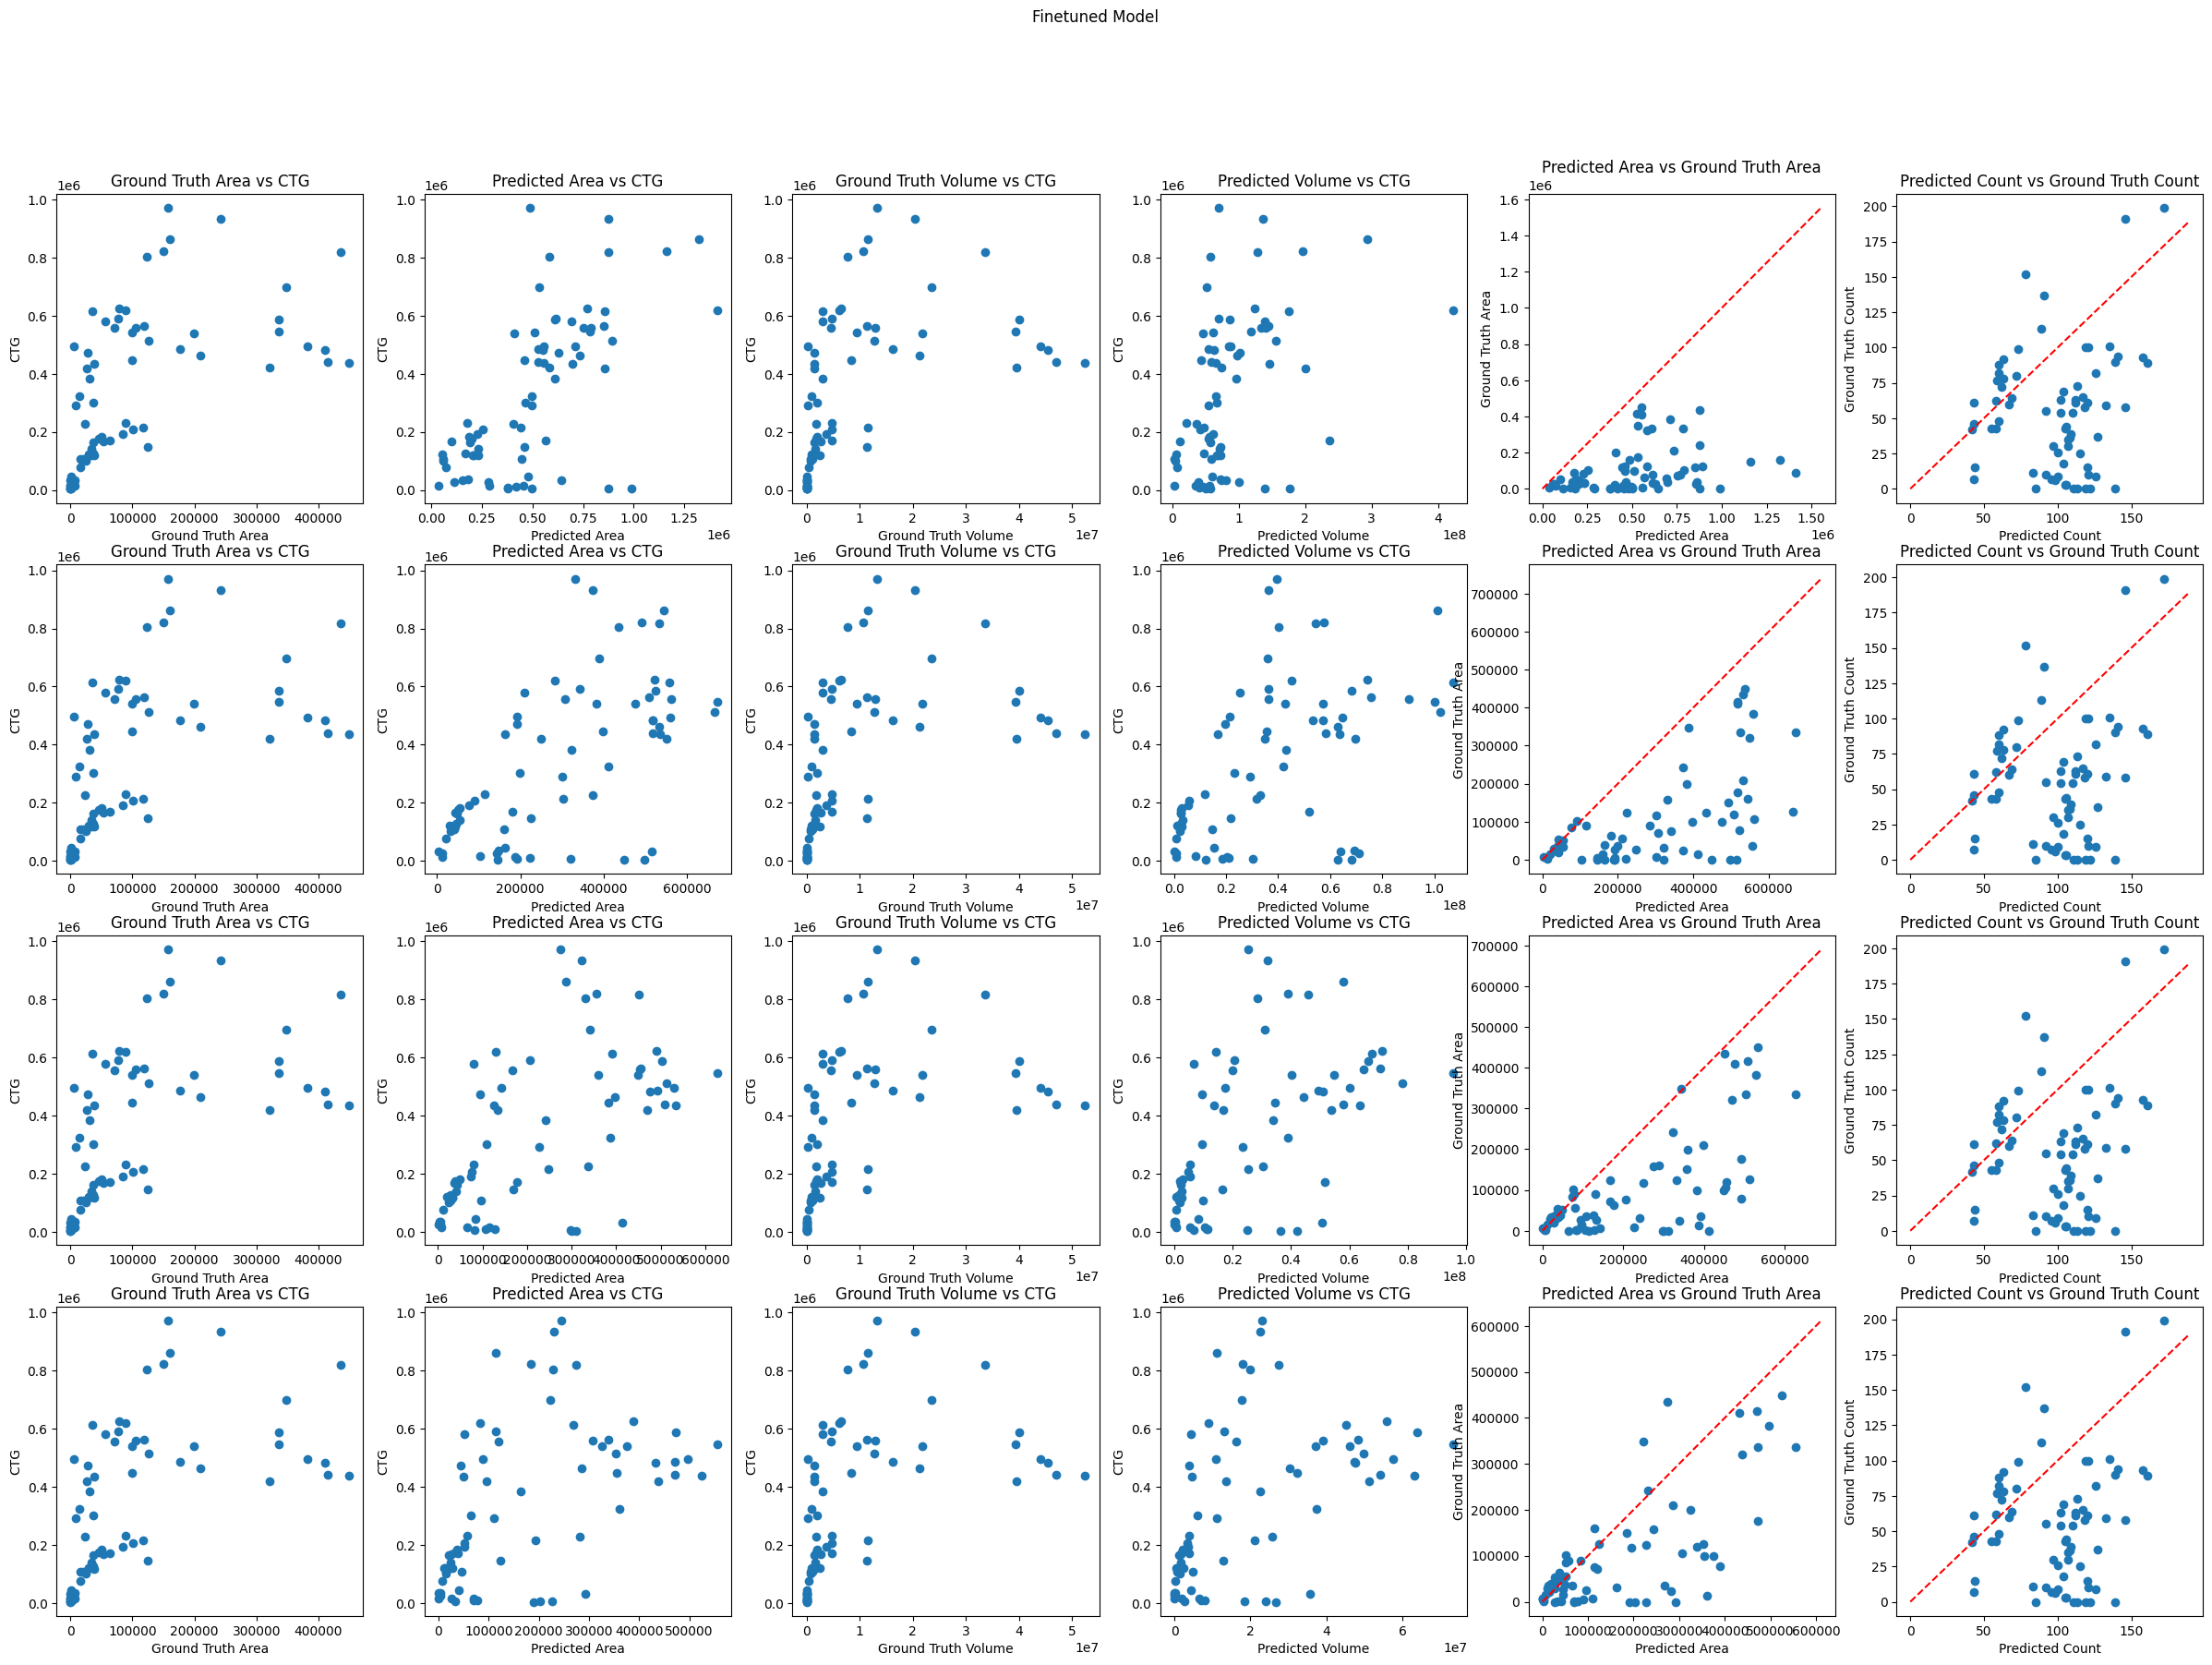

,confidence,pearson_gt_ctg,spearman_gt_ctg,pearson_pred_ctg,spearman_pred_ctg,pearson_gt_ctg_volume,spearman_gt_ctg_volume,pearson_pred_ctg_volume,spearman_pred_ctg_volume,pearson_pred_gt,spearman_pred_gt
0,0.0,0.592297,0.787587,0.653938,0.622484,0.505809,0.804217,0.45015,0.458615,0.326177,0.378153
1,0.5,0.592297,0.787587,0.636369,0.620265,0.505809,0.804217,0.530537,0.528523,0.618528,0.548067
2,0.75,0.592297,0.787587,0.604558,0.608785,0.505809,0.804217,0.570015,0.607209,0.700881,0.592633
3,0.9,0.592297,0.787587,0.532289,0.602053,0.505809,0.804217,0.507373,0.583242,0.732574,0.59579


In [13]:
plot_predictions(processed_predictions_pretrained)

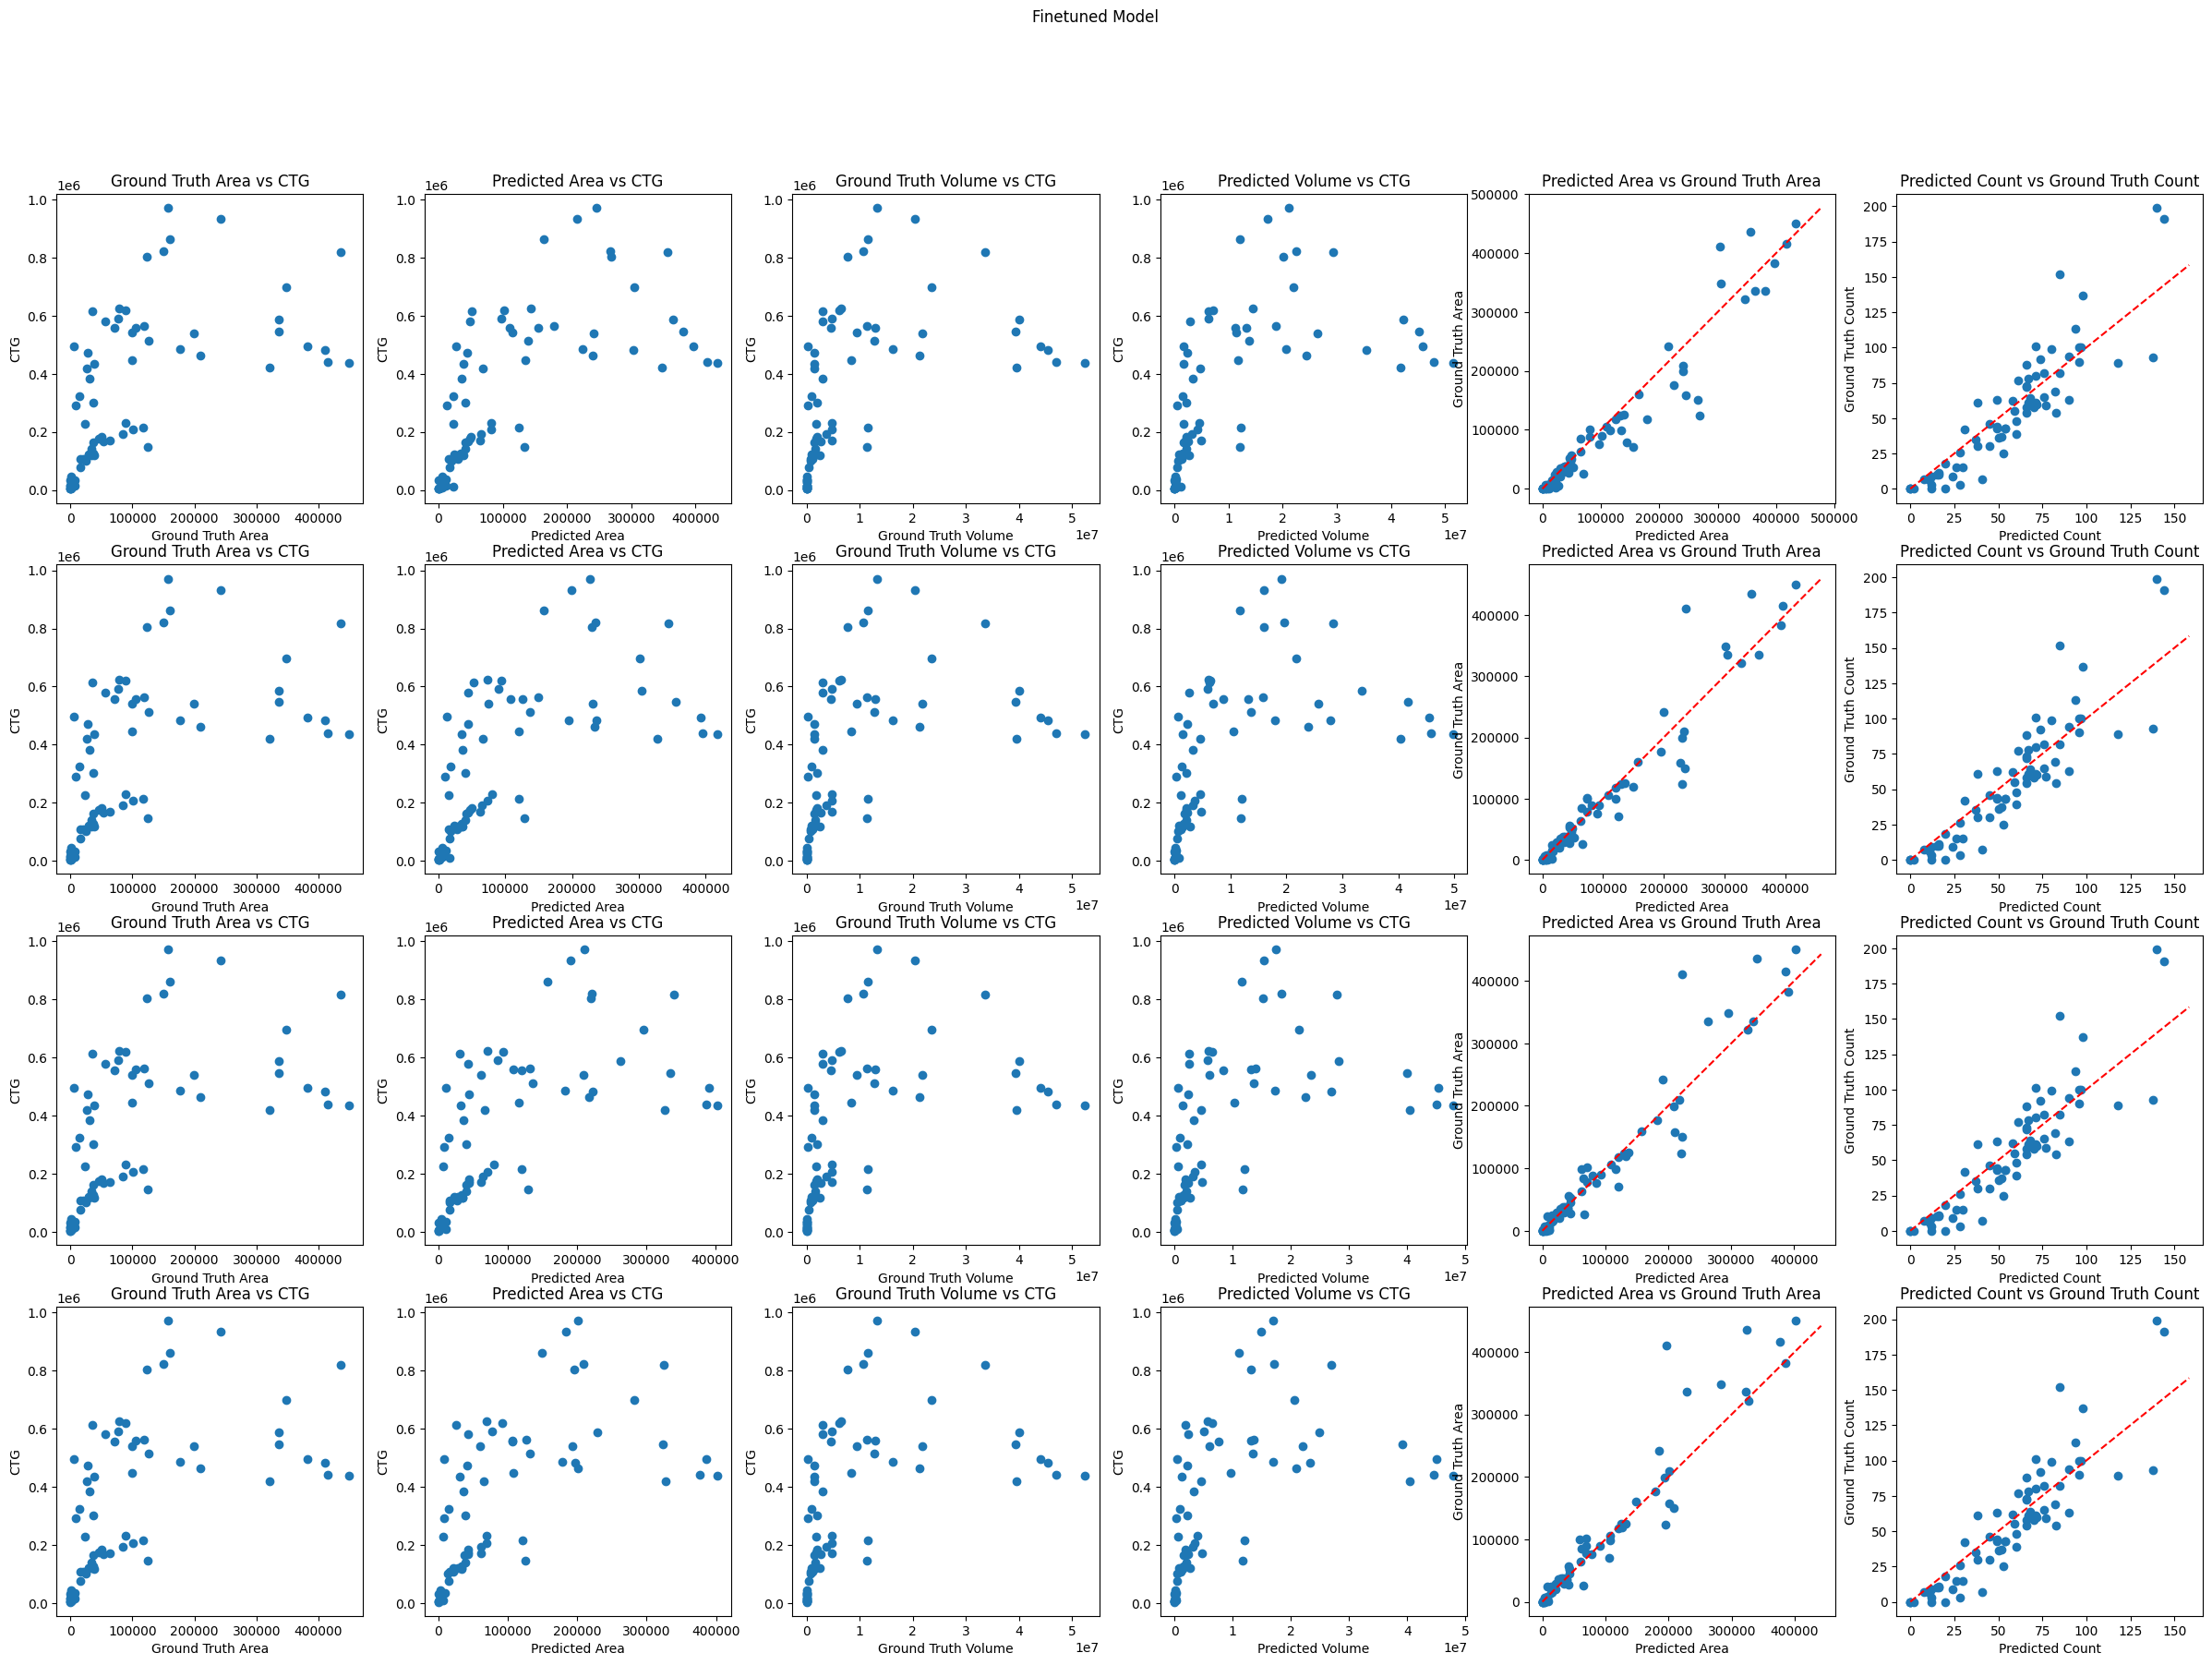

,confidence,pearson_gt_ctg,spearman_gt_ctg,pearson_pred_ctg,spearman_pred_ctg,pearson_gt_ctg_volume,spearman_gt_ctg_volume,pearson_pred_ctg_volume,spearman_pred_ctg_volume,pearson_pred_gt,spearman_pred_gt
0,0.0,0.592297,0.787587,0.682209,0.83455,0.505809,0.804217,0.585776,0.836351,0.959798,0.967938
1,0.5,0.592297,0.787587,0.660653,0.816083,0.505809,0.804217,0.560992,0.823447,0.961809,0.974177
2,0.75,0.592297,0.787587,0.651047,0.801386,0.505809,0.804217,0.549041,0.81544,0.961803,0.975528
3,0.9,0.592297,0.787587,0.638794,0.800679,0.505809,0.804217,0.536379,0.809715,0.958647,0.975753


In [14]:
plot_predictions(processed_predictions_finetuned)



In [15]:
# look at differences
pd.set_option('display.max_colwidth', None)
df["diff_gt"] = df["CTG_norm"] - df["gt_area_norm"]
df["diff_pred"] = df["CTG_norm"] - df["predicted_area_norm"]

print("### Images in ascending order of difference between CTG and ground truth area ###")
df.sort_values(by=["diff_gt"], ascending=False, inplace=True)
for id, row in df.sort_values(by=["diff_gt"], ascending=False).iterrows():
    print(f"Image: {row['image_path']},\nCTG: {row['CTG_norm']},\nGT area: {row['gt_area_norm']},\ndiff: {row['diff_gt']},\npredicted area: {row['predicted_area_norm']}")
    image = cv2.imread(row["image_path"])
    plt.imshow(image)
    plt.show()

NameError: name 'df' is not defined

In [ ]:
print("Images in ascending order of difference between CTG and predicted area")
for id, row in df.sort_values(by=["diff_pred"], ascending=False).iterrows():
    print(f"Image: {row['image_path']},\nCTG: {row['CTG_norm']},\nPredicted area: {row['predicted_area_norm']},\ndiff: {row['diff_pred_norm']}")
    image = cv2.imread(row["image_path"])
    plt.imshow(image)
    plt.show()

Images in ascending order of difference between CTG and predicted area


KeyError: 'diff_pred_norm'